# Data Analysis Template Notebook

Welcome to the Data Analysis Template Notebook! This notebook constitutes an example of how the data should be preprocessed and analysed. It follows the pipelines reported in the [Jupyter Book](https://vivineuro.github.io/Neuromatch-Data-Analysis-Team-Organization/WorkTogether/Imports%20%26%20Loading%20set%20up.html). Please do not hesitate to reach out to `#a-24-evaluation` if you have any questions or something in unclear.


<a id='Imports'></a>
## Imports set up

At the top of every notebook, we define an **Imports** section where all necessary packages and libraries should be imported. This ensures that all dependencies are loaded at the beginning of the notebook, making it easy to track what packages are in use.

In [1]:
!pip install tabulate
from tabulate import tabulate

# General imports
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import glob          # For file searching
import re            # For pattern matching
import itertools

# Visualization imports
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns            # Statistical data visualization

# Display high-quality plots in SVG format
from IPython import display
display.set_matplotlib_formats('svg')  # Recommended for better plot quality

# to restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# display max numer of columns. Change the value as needed.
pd.set_option('display.max_columns', 100)

<ipython-input-1-5f4beceb50cd>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')  # Recommended for better plot quality


<a id='Data-Loading'></a>
## Data Loading

In this section, we’ll use Google Drive to store and load datasets. The code below mounts Google Drive, finds all CSV files with a specified prefix in a given folder, and loads each CSV file into a dictionary of DataFrames for easy access.

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

folder_path = "/content/drive/MyDrive/Academies_DataAnalysis/July2024/DailySurveys/DL/TAs/"
file_prefix = "DL"  # Replace with your desired prefix

csv_files       = glob.glob(f"{folder_path}/{file_prefix}*.csv")
dataframes_dict = {file.split('/')[-1]: pd.read_csv(file) for file in csv_files}

# To access each DataFrame by filename, use the dictionary
# Example: Accessing the 'CSw1d1-Grid view.csv' file if it exists
dataframe_name = 'DLw2d1-Grid view' # Adjust the filename to match your data
if dataframe_name in dataframes_dict:
    df = dataframes_dict[dataframe_name]
    print(df.head())  # Display the first 5 rows
else:
    print(f"{dataframe_name} not found in the loaded files.")
print('*' * 50)

# Print the loaded dataframes
print("Loaded DataFrames:", dataframes_dict.keys())
print('*' * 50)

# Check the number of datasets loaded
len(dataframes_dict)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DLw2d1-Grid view not found in the loaded files.
**************************************************
Loaded DataFrames: dict_keys(['DLw2d1-Grid view.csv', 'DLw2d2-Grid view.csv', 'DLw2d3-Grid view.csv', 'DLw2d5-Grid view.csv', 'DLw3d2-Grid view.csv', 'DLw3d3-Grid view.csv', 'DLw3d4-Grid view.csv', 'DLw3d5-Grid view.csv', 'DLw3d1-Grid view.csv', 'DLw2d4-Grid view.csv'])
**************************************************


10

**NOTE: In 2024 we started delivering TAs daily surveys on the second week for CN and DL. The first week is missing, that's why we have 10 datasets**

<a id='Data-Cleaning-and-Preprocessing'></a>
## Data Cleaning and Preprocessing

The below function can be used for cleaning TAs daily surveys. Please find detailed explanations of it in the [Jupyter Book](https://vivineuro.github.io/Neuromatch-Data-Analysis-Team-Organization/WorkTogether/Imports%20%26%20Loading%20set%20up.html).

In [3]:
def clean_and_combine_data(
    dataframes_dict,
    TAs_apps_path,
    course_id,
    status,
    ST_apps_path,
    certificates_path,
    output_file='combined_df.csv'):

    """
    Cleans and combines dataframes, checks UID validity, handles duplicates, and saves the final combined dataframe.
    Additionally, loads the certificates dataset, adds the TA_role and certificate received based on matching UIDs.

    Parameters:
    - dataframes_dict: Dictionary with filenames as keys and DataFrames as values.
    - TAs_apps_path: Path to the TAs_apps dataset CSV file.
    - course_id: Course ID to filter the TAs_apps dataset.
    - status: Status to filter the TAs_apps dataset.
    - ST_apps_path: Path to the ST_apps dataset CSV file.
    - certificates_path: Path to the certificates dataset CSV file.
    - output_file: Filename to save the cleaned combined dataframe (default: 'combined_df.csv').
    """

    # Step 1: Add "WeekDay" column based on the filename pattern
    for filename, df in dataframes_dict.items():
        match = re.search(r'w\d+d\d+', filename)
        if match:
            df['WeekDay'] = match.group()
        else:
            print(f"No 'WeekDay' pattern found in filename: {filename}")

    # Step 2: Combine all DataFrames
    combined_df = pd.concat(dataframes_dict.values(), ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    print('-' * 80)
    print(' ')

    # Step 3: Load TAs_apps and filter by course_id and status
    TAs_apps = pd.read_csv(TAs_apps_path)
    TAs_apps_filtered = TAs_apps[(TAs_apps['course_id'] == course_id) & (TAs_apps['status'] == status)].copy()
    print("[INFO] Filtered TAs_apps dataset for course of interest and TA status = matched")
    print(f"The shape of this dataset is {TAs_apps_filtered.shape}")
    print('-' * 80)
    print(' ')

    # Load certificates dataset
    certificates = pd.read_csv(certificates_path)

    # Filter certificates for course_id and certificate type
    certificates = certificates[(certificates['course_id'] == course_id) & (certificates['certificate_type'].isin(['ta_certificate', 'project_ta_certificate', 'lead_ta_certificate']))]
    print(f"[INFO] Filtered certificates dataset for course_id = {course_id} and certificate_type")
    print(f"Certificates shape: {certificates.shape}")
    print('-' * 80)
    print(' ')

    # Create a new column 'TA_role' based on certificate_type values
    mapping = {
        'ta_certificate': 'Regular TA',
        'project_ta_certificate': 'Project TA',
        'lead_ta_certificate': 'Lead TA'}

    certificates['TA_role'] = certificates['certificate_type'].map(mapping)

    # Create mapping series for TA_role and certificate_type using unique_id as index
    TA_role_mapping = certificates.set_index('unique_id')['TA_role']
    certificate_type_mapping = certificates.set_index('unique_id')['certificate_type']

    # Map the values to TAs_apps_filtered based on unique_id
    TAs_apps_filtered['TA_role'] = TAs_apps_filtered['unique_id'].map(TA_role_mapping)
    TAs_apps_filtered['certificate_type'] = TAs_apps_filtered['unique_id'].map(certificate_type_mapping)

    # Step 4: Check that all UID in the combined dataframe are present in TAs_apps_filtered
    missing_values = combined_df.loc[~combined_df['uid'].isin(TAs_apps_filtered['unique_id']), 'uid']
    if not missing_values.empty:
        print(f"[WARNING]: {missing_values.nunique()} unique_id are not found in the TA_apps dataset filtered for matched and course_id")
        print("List:", missing_values.tolist())
        print('-' * 80)
        print(' ')

        # 4A: Check these missing UIDs in the FULL ST_apps
        ST_apps = pd.read_csv(ST_apps_path)
        print("[INFO] Checking whether the unique_id not found in the list of matched TAs are associated with students unique_id...")
        missing_in_ST_full = ST_apps[ST_apps['unique_id'].isin(missing_values)]
        found_uids_ST = missing_in_ST_full['unique_id'].unique()

        if found_uids_ST.size > 0:
            print("[INFO] Some of the missing UIDs were found in the students dataset:")
            for uid in found_uids_ST:
                uid_rows = missing_in_ST_full.loc[
                    missing_in_ST_full['unique_id'] == uid,
                    ['application_status', 'course_id']
                ]
                statuses = uid_rows['application_status'].unique()
                course_ids = uid_rows['course_id'].unique()
                print(f"  UID = {uid}, status = {list(statuses)}, course_id = {list(course_ids)}")

        # Count the number of rows before filtering
        original_count = combined_df.shape[0]

        # Count the number of rows that will remain after filtering
        remaining_count = combined_df[combined_df['uid'].isin(TAs_apps_filtered['unique_id'])].shape[0]

        # Calculate the number of rows that will be removed
        removed_count = original_count - remaining_count
        print('-' * 80)
        print(f"Number of rows to be removed: {removed_count}")
        print('-' * 80)
        print(' ')
        combined_df = combined_df[combined_df['uid'].isin(TAs_apps_filtered['unique_id'])]
        print("Removed rows with missing UIDs. New shape:", combined_df.shape)
        print('-' * 80)
        print(' ')

    combined_df = combined_df.merge(
        TAs_apps_filtered[['unique_id','TA_role', 'certificate_type', 'career_status']],
        left_on='uid',right_on='unique_id',
        how='left')

    # Step 5: Check for duplicates within each WeekDay and UID combination
    duplicates = combined_df[combined_df.duplicated(subset=['WeekDay', 'uid'], keep=False)]
    if not duplicates.empty:
        print(f"Duplicate entries found based on ['WeekDay', 'uid']: {len(duplicates)}")
        combined_df = combined_df.drop_duplicates(subset=['WeekDay', 'uid'], keep='first')
        print("Removed duplicates. New shape:", combined_df.shape)
        print('-' * 80)
        print(' ')

    # Step 6: Save the cleaned DataFrame to CSV
    combined_df.to_csv(output_file, index=False)
    print(f"Cleaned DataFrame saved to {output_file}")

    return combined_df


In [4]:
combined_df = clean_and_combine_data(
              dataframes_dict   = dataframes_dict,
              TAs_apps_path     = "/content/drive/MyDrive/Academies_DataAnalysis/General/TAs_ReceivedApp_from2021.csv", # to be updated in 2025
              course_id         = 13,       # Specify the course_id number of interest
              status            = "matched",   # Do NOT change the status
              ST_apps_path      = "/content/drive/MyDrive/Academies_DataAnalysis/General/Students_ReceivedApp_from2021.csv", # to be updated in 2025
              certificates_path = "/content/drive/MyDrive/Academies_DataAnalysis/General/Certificate2024.csv", # to be updated in 202
              output_file       = "cleaned_combined_df.csv")


Combined DataFrame shape: (103, 25)
--------------------------------------------------------------------------------
 
[INFO] Filtered TAs_apps dataset for course of interest and TA status = matched
The shape of this dataset is (36, 10)
--------------------------------------------------------------------------------
 
[INFO] Filtered certificates dataset for course_id = 13 and certificate_type
Certificates shape: (36, 7)
--------------------------------------------------------------------------------
 
Duplicate entries found based on ['WeekDay', 'uid']: 13
Removed duplicates. New shape: (96, 29)
--------------------------------------------------------------------------------
 
Cleaned DataFrame saved to cleaned_combined_df.csv


**View the first and last 5 rows of the dataset**

In [5]:
combined_df.head()

,uid,pod,Q14,Q15,Q16,Q17,Q18,WeekDay,Q1,Q2,Q3,Q4,Q5,1,Q6,2,Q7,Q8,Q9,Q10,Q11,Q12,Q13,podnames,Field 12,unique_id,TA_role,certificate_type,career_status
0,8e5f2663-692b-47f0-b9f8-c779d008b51d,Ample Calendula,"I think the progress is quite good in my pod, ...",11.00,11.00,No,3.00,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8e5f2663-692b-47f0-b9f8-c779d008b51d,Regular TA,ta_certificate,masters_student
1,78a5c041-9a28-4fbb-87ce-4e966347169b,Appreciated Marigold,7-8 are attending the project. 3-4 for tutoria...,4.00,8.00,Maybe - Need more info,4.00,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78a5c041-9a28-4fbb-87ce-4e966347169b,Regular TA,ta_certificate,phd_student
2,4cc51935-39e2-4b5b-b0f9-0e5fa8362cf8,Cheerful Honeysuckle,They're very quiet sometimes and very much shy...,12.00,12.00,Maybe - Need more info,7.00,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4cc51935-39e2-4b5b-b0f9-0e5fa8362cf8,Regular TA,ta_certificate,masters_student
3,c451c655-d680-4f20-8afb-e98922af1e38,Efficient Fleabane,Very active students,11.00,11.00,No,7.00,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c451c655-d680-4f20-8afb-e98922af1e38,Regular TA,ta_certificate,lecturer_professor_faculty
4,2dfd46a9-9a87-4adb-a49b-cab5b158f03c,Exuberant Hibiscus,NaN,9.00,9.00,No,5.00,w2d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2dfd46a9-9a87-4adb-a49b-cab5b158f03c,Regular TA,ta_certificate,lecturer_professor_faculty


In [6]:
combined_df.tail()

,uid,pod,Q14,Q15,Q16,Q17,Q18,WeekDay,Q1,Q2,Q3,Q4,Q5,1,Q6,2,Q7,Q8,Q9,Q10,Q11,Q12,Q13,podnames,Field 12,unique_id,TA_role,certificate_type,career_status
98,d4d35967-32c5-4fd5-be69-ef18b88a7db6,Silly Dahlia,NaN,NaN,NaN,NaN,NaN,w2d4,NaN,NaN,5.00,NaN,NaN,Regular TA,C,5.00,D,D,C,B,NaN,NaN,NaN,NaN,NaN,d4d35967-32c5-4fd5-be69-ef18b88a7db6,Regular TA,ta_certificate,lecturer_professor_faculty
99,13f7252b-8521-4464-a390-9633e9e68ae1,Sleepy Oenethera,NaN,NaN,NaN,NaN,NaN,w2d4,NaN,NaN,4.00,NaN,NaN,Lead TA,C,4.00,D,C,C,B,NaN,NaN,NaN,NaN,NaN,13f7252b-8521-4464-a390-9633e9e68ae1,Lead TA,lead_ta_certificate,postdoc
100,7134d1ab-2933-4313-a847-3d715ceca97f,Splendid Meconopsis,NaN,NaN,NaN,NaN,NaN,w2d4,NaN,NaN,4.00,NaN,NaN,Regular TA,E,4.00,E,E,B,A,NaN,NaN,NaN,NaN,NaN,7134d1ab-2933-4313-a847-3d715ceca97f,Regular TA,ta_certificate,industry
101,06e9d3ad-ae41-4147-a46b-ac6c31b6a416,"Successful Strawflower,Upbeat Tuberose,Fantast...",NaN,NaN,NaN,NaN,NaN,w2d4,NaN,NaN,3.00,NaN,NaN,Project TA,C,4.00,NaN,NaN,B,NaN,H,C,NaN,NaN,NaN,06e9d3ad-ae41-4147-a46b-ac6c31b6a416,Project TA,project_ta_certificate,masters_student
102,a445dce5-6f90-446d-902a-ab673ec6ec57,Thriving Kniphofia,NaN,NaN,NaN,NaN,NaN,w2d4,NaN,NaN,3.00,NaN,NaN,Regular TA,D,4.00,D,D,B,B,NaN,NaN,NaN,NaN,NaN,a445dce5-6f90-446d-902a-ab673ec6ec57,Regular TA,ta_certificate,other


**Understand the shape of the dataset**

In [7]:
print("There are", combined_df.shape[0], 'rows and', combined_df.shape[1], "columns.")

There are 96 rows and 29 columns.


**Check the data types of the columns in the dataset**

In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 102
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               96 non-null     object 
 1   pod               96 non-null     object 
 2   Q14               12 non-null     object 
 3   Q15               9 non-null      float64
 4   Q16               9 non-null      float64
 5   Q17               9 non-null      object 
 6   Q18               9 non-null      float64
 7   WeekDay           96 non-null     object 
 8   Q1                1 non-null      object 
 9   Q2                0 non-null      float64
 10  Q3                87 non-null     float64
 11  Q4                0 non-null      float64
 12  Q5                0 non-null      float64
 13  1                 87 non-null     object 
 14  Q6                87 non-null     object 
 15  2                 87 non-null     float64
 16  Q7                65 non-null     object 
 17  Q8 

**There are different empty columns**. From the [DataDescriptor](https://docs.google.com/spreadsheets/d/13Ebqe0RHM5h3Rl_4stLdjY7_I1tqTpZaDHq-1shTgLU/edit?gid=1419310288#gid=1419310288) we can see that :
- Q2, Q4 and Q5 are conditional questions
- podnames can be deleted as names of pods are in the `pod` columns
- `Field 12`is not present
- `unique_id` is the same as `uid`

**We can remove these columns**

In [9]:
combined_df = combined_df.drop(columns=['Q2', 'Q4', 'Q5', 'podnames', 'Field 12', 'unique_id'])

In [10]:
# combined_df.describe().T
combined_df.describe(include = 'all').T # if you want to include object too

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
uid,96,21,4cc51935-39e2-4b5b-b0f9-0e5fa8362cf8,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pod,96,25,Cheerful Honeysuckle,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q14,12,12,"I think the progress is quite good in my pod, ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q15,9.00,NaN,NaN,NaN,8.44,2.83,4.00,7.00,9.00,11.00,12.00
Q16,9.00,NaN,NaN,NaN,8.78,2.44,5.00,7.00,9.00,11.00,12.00
Q17,9,2,Maybe - Need more info,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q18,9.00,NaN,NaN,NaN,4.89,2.09,2.00,3.00,5.00,7.00,8.00
WeekDay,96,10,w2d4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q1,1,1,"C,D",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q3,87.00,NaN,NaN,NaN,4.33,0.73,3.00,4.00,4.00,5.00,5.00


# Function to define colors for plotting

In [11]:
# Define colors

colors_cma = [
    "#313f76",
    "#a2bbd4",
    "#67ada9",
    "#e18256",
    "#596a63",
    "#f0ba7d"]

colors_nma = [
    "#D18D20",
    "#FF7676",
    "#008CBF",
    "#43439E"]

# Option to choose between sets
def get_colors(name="CMA"):
    """
    Returns a list of colors based on the name provided.
    Supported values:
    - "CMA" for CMA colors
    - "NMA" for NMA colors
    - "ALL" for both CMA and NMA colors combined
    """
    if name.upper() == "CMA":
        return colors_cma
    elif name.upper() == "NMA":
        return colors_nma
    elif name.upper() == "ALL":
        return colors_cma + colors_nma
    else:
        raise ValueError("Invalid color set name. Use 'CMA', 'NMA', or 'ALL'.")

# Examples of usage:
# cma_colors = get_colors("CMA")   # CMA-only colors
# nma_colors = get_colors("NMA")   # NMA-only colors
# all_colors = get_colors("ALL")   # All colors combined

# Completition rate based on the number of TAs that received a certificate


In [12]:
certificates_path = "/content/drive/MyDrive/Academies_DataAnalysis/General/Certificate2024.csv"
certificates       = pd.read_csv(certificates_path)

certificate_DL = certificates[
    (certificates['course_id'] == 13) &
    (certificates['certificate_type'].isin(['ta_certificate', 'project_ta_certificate', 'lead_ta_certificate']))].copy()

certificate_DL.head(2)
certificate_DL.shape

(36, 7)

In [13]:
certificate_DL['certificate_type'].value_counts()

,count
certificate_type,
ta_certificate,22
project_ta_certificate,7
lead_ta_certificate,7


In [14]:
role_mapping = {
    'ta_certificate': 'Regular TA',
    'project_ta_certificate': 'Project TA',
    'lead_ta_certificate': 'Lead TA'}

certificate_DL['TA_role'] = certificate_DL['certificate_type'].map(role_mapping)

# Count the total number of TAs per role based on certificates (denominator for each role)
total_per_role = certificate_DL.groupby('TA_role')['unique_id'].nunique().reset_index()
total_per_role.rename(columns={'unique_id': 'total_TAs'}, inplace=True)
print(f"Total TAs per role: \n{total_per_role}")
print('-' * 80)
print(' ')

survey_by_role = combined_df.groupby(['WeekDay', 'TA_role'])['uid'].nunique().reset_index()
# Merge the survey data with the total counts per TA_role
survey_by_role = survey_by_role.merge(total_per_role, on='TA_role', how='left')

# Calculate the weekly completion rate per TA_role
survey_by_role['completion_rate'] = (survey_by_role['uid'] / survey_by_role['total_TAs']) * 100

print("Weekly survey completion rate per TA_role: \n")
print(survey_by_role)

Total TAs per role: 
      TA_role  total_TAs
0     Lead TA          7
1  Project TA          7
2  Regular TA         22
--------------------------------------------------------------------------------
 
Weekly survey completion rate per TA_role: 

   WeekDay     TA_role  uid  total_TAs  completion_rate
0     w2d1     Lead TA    1          7            14.29
1     w2d1  Regular TA    8         22            36.36
2     w2d2     Lead TA    1          7            14.29
3     w2d2  Project TA    2          7            28.57
4     w2d2  Regular TA    8         22            36.36
5     w2d3     Lead TA    1          7            14.29
6     w2d3  Project TA    2          7            28.57
7     w2d3  Regular TA    5         22            22.73
8     w2d4     Lead TA    1          7            14.29
9     w2d4  Project TA    4          7            57.14
10    w2d4  Regular TA    7         22            31.82
11    w2d5  Project TA    1          7            14.29
12    w2d5  Regular TA 

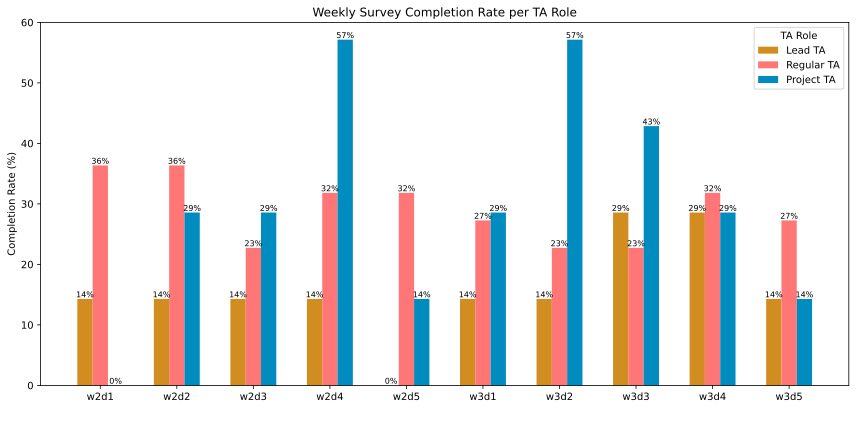

In [15]:
weekdays = sorted(survey_by_role['WeekDay'].unique())
roles = survey_by_role['TA_role'].unique()

# Set up the bar chart parameters
bar_width = 0.2
x = np.arange(len(weekdays))
colors = get_colors("NMA")

fig, ax = plt.subplots(figsize=(12, 6))

for i, role in enumerate(roles):
    # Filter for the current role and index by WeekDay
    role_data = survey_by_role[survey_by_role['TA_role'] == role].set_index('WeekDay')
    # Get the completion rates in the order of weekdays (default to 0 if missing)
    rates = [role_data.loc[wd, 'completion_rate'] if wd in role_data.index else 0 for wd in weekdays]

    # Calculate positions for the bars
    pos = x + i * bar_width

    # Plot the bars for the current role, using a color from the colors list
    bars = ax.bar(pos, rates, bar_width, label=role, color=colors[i % len(colors)])

    # Annotate
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.0f}%',
            ha='center',
            va='bottom',
            fontsize=8)

ax.set_xlabel(' ')
ax.set_ylabel('Completion Rate (%)')
ax.set_title('Weekly Survey Completion Rate per TA Role')

ax.set_xticks(x + bar_width * (len(roles) - 1) / 2)
ax.set_xticklabels(weekdays)
ax.legend(title='TA Role')

plt.tight_layout()
plt.savefig('SurveyCompletionRate.png', dpi=400)
plt.show()

# TAs experience with the pod

Question named '2' on Airtable. The name of the questions are not particularly useful. Please check the [data descriptor](https://drive.google.com/drive/folders/1u-aG6doOucNUQoFnGyYiuocXddJtc_23) for understanding what data have been collected.

Using a Likert scale from `1 = Very unsatisfactory` to 5 - `Very satisfactory`, TAs rate their overall experience with the pod.

In [16]:
# @title
# Check in which day these questions are present.

missing_2 = combined_df.groupby('WeekDay')['2'].value_counts(normalize=True) *100
print(missing_2)

WeekDay  2   
w2d2     5.00   72.73
         4.00   18.18
         3.00    9.09
w2d3     5.00   50.00
         4.00   37.50
         3.00   12.50
w2d4     4.00   41.67
         5.00   33.33
         3.00   16.67
         1.00    8.33
w2d5     4.00   50.00
         5.00   50.00
w3d1     5.00   55.56
         4.00   33.33
         3.00   11.11
w3d2     4.00   60.00
         5.00   40.00
w3d3     5.00   70.00
         4.00   20.00
         3.00   10.00
w3d4     5.00   45.45
         3.00   36.36
         4.00   18.18
w3d5     5.00   62.50
         4.00   25.00
         3.00   12.50
Name: proportion, dtype: float64


**We dont ask this question in w2d1**

In [17]:
# @title
Perc_2 = combined_df.groupby('WeekDay')['2'].value_counts(normalize=True) * 100
print(Perc_2)

WeekDay  2   
w2d2     5.00   72.73
         4.00   18.18
         3.00    9.09
w2d3     5.00   50.00
         4.00   37.50
         3.00   12.50
w2d4     4.00   41.67
         5.00   33.33
         3.00   16.67
         1.00    8.33
w2d5     4.00   50.00
         5.00   50.00
w3d1     5.00   55.56
         4.00   33.33
         3.00   11.11
w3d2     4.00   60.00
         5.00   40.00
w3d3     5.00   70.00
         4.00   20.00
         3.00   10.00
w3d4     5.00   45.45
         3.00   36.36
         4.00   18.18
w3d5     5.00   62.50
         4.00   25.00
         3.00   12.50
Name: proportion, dtype: float64


In [18]:
# @title
Global_perc_2 = combined_df['2'].value_counts(normalize=True) * 100
print(Global_perc_2)

2
5.00   52.87
4.00   33.33
3.00   12.64
1.00    1.15
Name: proportion, dtype: float64


In [19]:
# @title
ordered_categories = [
    'w2d1', 'w2d2', 'w2d3', 'w2d4', 'w2d5',
    'w3d1', 'w3d2', 'w3d3', 'w3d4', 'w3d5']

# Convert WeekDay to categorical with the correct order
combined_df['WeekDay'] = pd.Categorical(combined_df['WeekDay'], categories=ordered_categories, ordered=True)

<ipython-input-20-afc45aa028bd>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=filtered_df, x='WeekDay', y='2', order=order, palette=palette_dict)


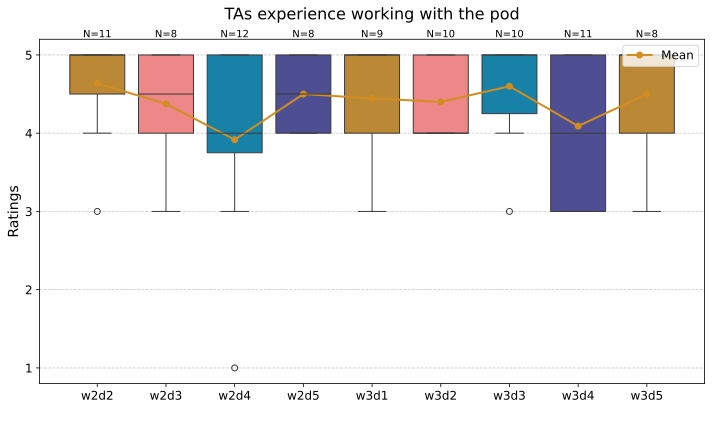

In [20]:
# @title
mean_values = combined_df.groupby('WeekDay', observed=False)['2'].mean()

# Replace 0 with NaN
mean_values = mean_values.replace(0, np.nan).dropna()

# Count unique uids per weekday
uids_answered_per_weekday = combined_df.groupby('WeekDay', observed=False)['uid'].nunique()

# Drop days where mean_values is NaN
uids_answered_per_weekday = uids_answered_per_weekday[mean_values.index]

# Filter the dataset to remove missing WeekDays
filtered_df = combined_df[combined_df['WeekDay'].isin(mean_values.index)]

colors = get_colors("NMA")

order = sorted(filtered_df['WeekDay'].unique())

# Build a dictionary mapping each weekday to a color.
palette_dict = {day: colors[i % len(colors)] for i, day in enumerate(order)}

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=filtered_df, x='WeekDay', y='2', order=order, palette=palette_dict)
xticks_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]
xticks_labels = [tick.get_text() for tick in ax.get_xticklabels()]

# Add a line for the mean
plt.plot(mean_values.index, mean_values.values, color=colors[0], marker='o', linestyle='-', linewidth=2, label="Mean")

# Annotate
for label, x_position in zip(xticks_labels, xticks_positions):
    if label in uids_answered_per_weekday.index:  # Only annotate valid days
        plt.text(x_position, 5.2, f'N={uids_answered_per_weekday[label]}',
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title("TAs experience working with the pod", fontsize=16, pad=20)
plt.xlabel(" ")
plt.ylabel("Ratings", fontsize=14)
plt.yticks([1, 2, 3, 4, 5], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc = 'upper right', fontsize=12)

plt.tight_layout()
plt.savefig('Podrating.png', dpi=400)
plt.show()

**Obersvations**

*   86% of TAs rated their experience working with the pod as 5 = Very satisfied or 4 = Satisfied.
*   W2D4 and W3D4 have slightly lower ratings.

# Difficulties faced while working with the pod

This question is conditional to the previous one (2). Only TAs that answered `Very Unsatisfactory` or `Unsatisfactory` could answer this question.

In [21]:
# @title
combined_df.groupby('uid')['Q1'].value_counts()

,,count
uid,Q1,
78a5c041-9a28-4fbb-87ce-4e966347169b,"C,D",1


In [22]:
# @title
combined_df.groupby(['WeekDay'])['Q1'].value_counts()

<ipython-input-22-bb88c2edab1c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_df.groupby(['WeekDay'])['Q1'].value_counts()


,,count
WeekDay,Q1,
w2d1,"C,D",0
w2d2,"C,D",0
w2d3,"C,D",0
w2d4,"C,D",1
w2d5,"C,D",0
w3d1,"C,D",0
w3d2,"C,D",0
w3d3,"C,D",0
w3d4,"C,D",0


**Only 1 TA asnwered this question in for w2d4**

Difficulties specified are:
1. Lack of clarity in the task instructions <br>
2. 'Other' - the TA did not explain it further


# TAs experience working with the project group
Mandatory question <br>

On a scale of 1-5, please rate your overall experience working with the project group(s) today. <br>
1 = Very unsatisfactory -- 5 = Very satisfactory

In [23]:
# @title
Perc_Q3 = combined_df.groupby('WeekDay')['Q3'].value_counts(normalize=True) * 100
print(Perc_Q3)

WeekDay  Q3  
w2d1     3.00    0.00
         4.00    0.00
         5.00    0.00
w2d2     5.00   45.45
         4.00   36.36
         3.00   18.18
w2d3     3.00   37.50
         4.00   37.50
         5.00   25.00
w2d4     5.00   50.00
         4.00   33.33
         3.00   16.67
w2d5     5.00   62.50
         4.00   25.00
         3.00   12.50
w3d1     4.00   55.56
         5.00   44.44
         3.00    0.00
w3d2     5.00   50.00
         4.00   40.00
         3.00   10.00
w3d3     5.00   50.00
         4.00   40.00
         3.00   10.00
w3d4     5.00   54.55
         4.00   27.27
         3.00   18.18
w3d5     5.00   50.00
         4.00   37.50
         3.00   12.50
Name: proportion, dtype: float64


<ipython-input-23-f37fcbd663c9>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Perc_Q3 = combined_df.groupby('WeekDay')['Q3'].value_counts(normalize=True) * 100


In [24]:
Global_perc_Q1P = combined_df['Q3'].value_counts(normalize=True) * 100
print(Global_perc_Q1P)

Q3
5.00   48.28
4.00   36.78
3.00   14.94
Name: proportion, dtype: float64


<ipython-input-25-b75b3c7a42fc>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = combined_df.groupby('WeekDay')['Q3'].mean()
<ipython-input-25-b75b3c7a42fc>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uids_answered_per_weekday = combined_df.groupby('WeekDay')['uid'].nunique()
<ipython-input-25-b75b3c7a42fc>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=filtered_df, x='WeekDay', y='Q3', order=order, palette=palette_dict) # colors

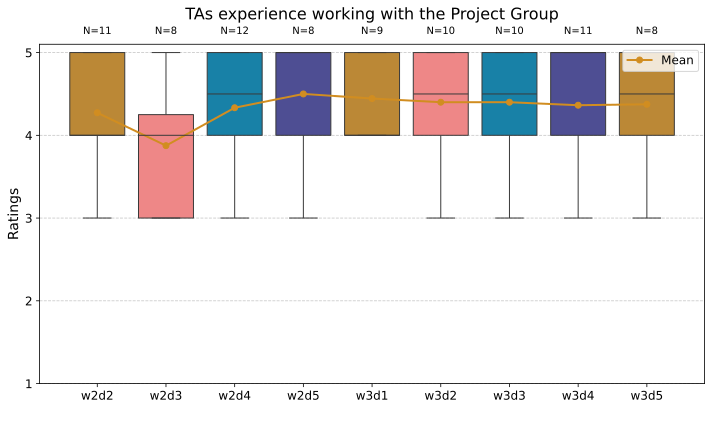

In [25]:
# @title
mean_values = combined_df.groupby('WeekDay')['Q3'].mean()

# Replace 0 with NaN
mean_values = mean_values.replace(0, np.nan).dropna()

# Count unique uids per weekday
uids_answered_per_weekday = combined_df.groupby('WeekDay')['uid'].nunique()

# Drop days where mean_values is NaN
uids_answered_per_weekday = uids_answered_per_weekday[mean_values.index]

# Filter the dataset to remove missing WeekDays
filtered_df = combined_df[combined_df['WeekDay'].isin(mean_values.index)]


# Plot the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=filtered_df, x='WeekDay', y='Q3', order=order, palette=palette_dict) # colors, order and dict specified before

xticks_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]
xticks_labels = [tick.get_text() for tick in ax.get_xticklabels()]

# Add a line for the mean
plt.plot(mean_values.index, mean_values.values, color=colors[0], marker='o', linestyle='-', linewidth=2, label="Mean")

# Annotate
for label, x_position in zip(xticks_labels, xticks_positions):
    if label in uids_answered_per_weekday.index:  # Only annotate valid days
        plt.text(x_position, 5.2, f'N={uids_answered_per_weekday[label]}',
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title("TAs experience working with the Project Group", fontsize=16, pad=25)
plt.xlabel(" ")
plt.ylabel("Ratings", fontsize=14)
plt.yticks([1, 2, 3, 4, 5], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc = 'upper right', fontsize=12)

plt.tight_layout()
plt.savefig('TAs_experience_project.png', dpi=400)
plt.show()

- 85% of TAs rated their experience with the project group as satisfactory and very satisfactory.
- Only w2d3 has a lower rate compared to the other days.
- In general, we obseve a slight decline in TAs ratings over time.

# Hours worked by day


In [26]:
count_Q6 = combined_df.groupby(['WeekDay', '1'])['Q6'].count()
print(count_Q6)

WeekDay  1          
w2d1     Lead TA        0
         Project  TA    0
         Regular TA     0
w2d2     Lead TA        1
         Project  TA    2
         Regular TA     8
w2d3     Lead TA        1
         Project  TA    2
         Regular TA     5
w2d4     Lead TA        1
         Project  TA    4
         Regular TA     7
w2d5     Lead TA        0
         Project  TA    1
         Regular TA     7
w3d1     Lead TA        1
         Project  TA    2
         Regular TA     6
w3d2     Lead TA        1
         Project  TA    4
         Regular TA     5
w3d3     Lead TA        1
         Project  TA    3
         Regular TA     6
w3d4     Lead TA        2
         Project  TA    2
         Regular TA     7
w3d5     Lead TA        1
         Project  TA    1
         Regular TA     6
Name: Q6, dtype: int64


<ipython-input-26-b34b29140941>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_Q6 = combined_df.groupby(['WeekDay', '1'])['Q6'].count()


In [27]:
# @title
mapping_numeric = {
    'A': 4.5,   # 4-5 hours -> midpoint 4.5
    'B': 5.5,   # 5-6 hours -> midpoint 5.5
    'C': 7.5,   # 7-8 hours -> midpoint 7.5
    'D': 8.5,   # 8-9 hours -> midpoint 8.5
    'E': 9.5}    # More than 9 hours -> estimate as 9.5
combined_df['Q6_numeric'] = combined_df['Q6'].map(mapping_numeric)


mapping_Q6 = {
    'A': '4-5 hours',
    'B': '5-6 hours',
    'C': '7-8 hour',
    'D': '8-9 hours',
    'E': 'More than 9 hours'}
combined_df['Q6_text'] = combined_df['Q6'].map(mapping_Q6)

# Calculate the overall average number of hours
average_hours_overall = round(combined_df['Q6_numeric'].mean(),2)
print("Overall average hours:", average_hours_overall)
print(' ')
print('*' *50)

# Calculate the average hours per WeekDay
average_hours_by_weekday = combined_df.groupby('WeekDay')['Q6_numeric'].mean()
print("Average hours per WeekDay:")
print(average_hours_by_weekday)
print(' ')
print('*' *50)

average_hours_TArole = combined_df.groupby('1')['Q6_numeric'].mean()
print("Average hours per TA Role:")
print(average_hours_TArole)

Overall average hours: 7.75
 
**************************************************
Average hours per WeekDay:
WeekDay
w2d1    NaN
w2d2   7.95
w2d3   7.62
w2d4   7.42
w2d5   7.75
w3d1   8.06
w3d2   8.10
w3d3   7.60
w3d4   7.59
w3d5   7.75
Name: Q6_numeric, dtype: float64
 
**************************************************
Average hours per TA Role:
1
Lead TA       6.83
Project  TA   7.45
Regular TA    8.01
Name: Q6_numeric, dtype: float64


<ipython-input-27-594d3dfd456f>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_hours_by_weekday = combined_df.groupby('WeekDay')['Q6_numeric'].mean()


In [28]:
# @title
Perc_Q6 = combined_df.groupby('WeekDay')['Q6_text'].value_counts(normalize=True) * 100
#Perc_Q6

<ipython-input-28-e66ce2de3e89>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Perc_Q6 = combined_df.groupby('WeekDay')['Q6_text'].value_counts(normalize=True) * 100


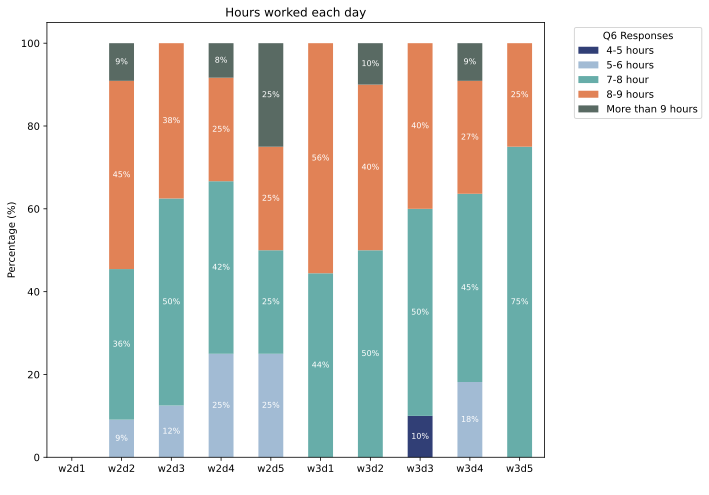

In [29]:
# @title
nma_colors = get_colors("ALL")

# Convert the Series to a DataFrame and reset the index
perc_q6_df = Perc_Q6.reset_index(name='Percentage')

perc_q6_pivot = perc_q6_df.pivot(index='WeekDay', columns='Q6_text', values='Percentage')

# Create the stacked bar plot
ax = perc_q6_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), color=nma_colors, rot=0)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Hours worked each day')

# Legend outside the plot
plt.legend(title='Q6 Responses', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate segments with a non-zero value

            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f'{height:.0f}%', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig('hours_worked_daily.png', dpi=400)
plt.show()

In [30]:
# @title
perc_q6 = combined_df.groupby(['1', 'WeekDay'], observed=True)['Q6_text'].value_counts(normalize=True) * 100

perc_q6_df = perc_q6.reset_index(name='Percentage')

In [31]:
perc_q6_df

,1,WeekDay,Q6_text,Percentage
0,Lead TA,w2d2,5-6 hours,100.00
1,Lead TA,w2d3,5-6 hours,100.00
2,Lead TA,w2d4,7-8 hour,100.00
3,Lead TA,w3d1,7-8 hour,100.00
4,Lead TA,w3d2,7-8 hour,100.00
5,Lead TA,w3d3,7-8 hour,100.00
6,Lead TA,w3d4,5-6 hours,50.00
7,Lead TA,w3d4,7-8 hour,50.00
8,Lead TA,w3d5,7-8 hour,100.00
9,Project TA,w2d2,7-8 hour,100.00


<ipython-input-32-7db453a6bd5a>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
<ipython-input-32-7db453a6bd5a>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
<ipython-input-32-7db453a6bd5a>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


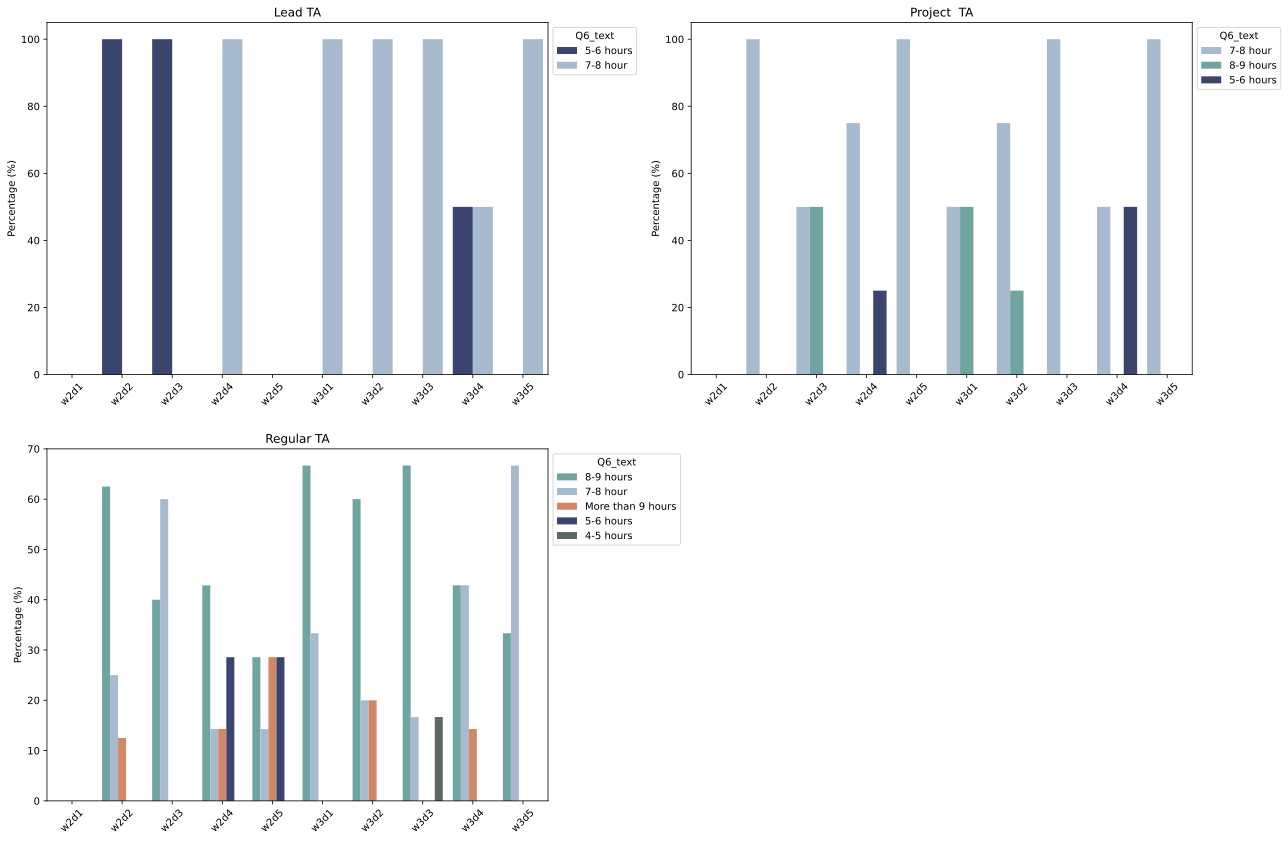

In [32]:
# Grouped bar plots for each category of '1'
unique_categories = perc_q6_df['1'].unique()

all_colors = get_colors("ALL")

q6_categories = perc_q6_df['Q6_text'].unique()
color_map = dict(zip(q6_categories, all_colors[:len(q6_categories)]))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot for each category
for i, category in enumerate(unique_categories):
    subset = perc_q6_df[perc_q6_df['1'] == category]
    sns.barplot(data=subset, x="WeekDay", y="Percentage", hue="Q6_text", ax=axes[i], palette=color_map)
    axes[i].set_title(f"{category}")
    axes[i].set_xlabel(" ")
    axes[i].set_ylabel("Percentage (%)")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].legend(title="Q6_text", bbox_to_anchor=(1, 1))

# Remove the extra subplot if we have only three categories
if len(unique_categories) == 3:
    fig.delaxes(axes[3])  # Remove the fourth subplot

plt.tight_layout()
plt.savefig('Working hours.png', dpi=400)
plt.show()

# Hours spent with the pod during tutorial

*non mandatory* - *Only for Lead and Regular TA*

Approximately how many hours did you spend with your pod during the coursework period (including any breaks taken during tutorials)?


In [33]:
mapping_Q7 = {
    'A': '1-2 hours',
    'B': '2-3 hours',
    'C': '3-4 hours',
    'D': '4-5 hours',
    'E': '5-6 hours',
    'D': 'More than 6 hours'}

combined_df['Q7'] = combined_df['Q7'].map(mapping_Q7)

In [34]:
perc_q7 = combined_df.groupby('WeekDay')['Q7'] \
                     .value_counts(normalize=True) * 100

perc_q7_df = perc_q7.reset_index(name='Percentage')

<ipython-input-34-def53c1bee50>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perc_q7 = combined_df.groupby('WeekDay')['Q7'] \


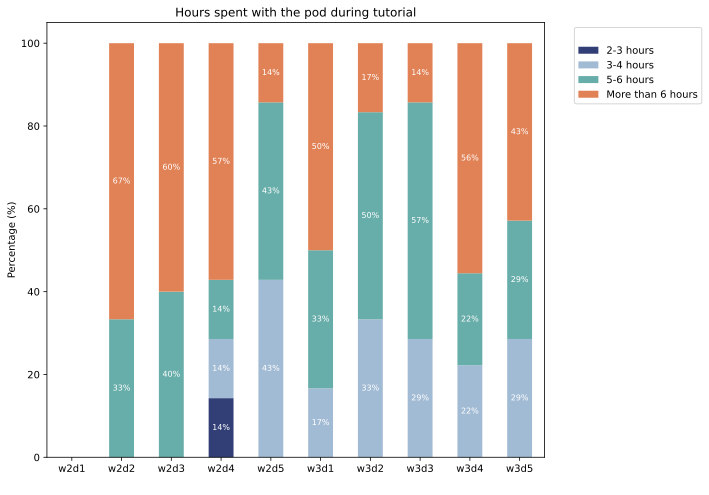

In [35]:
# @title
nma_colors = get_colors("ALL")

perc_q7_pivot = perc_q7_df.pivot(index='WeekDay', columns='Q7', values='Percentage')

# Create the stacked bar plot
ax = perc_q7_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), color=nma_colors, rot=0)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Hours spent with the pod during tutorial')

# Legend outside the plot
plt.legend(title=' ', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate segments with a non-zero value

            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f'{height:.0f}%', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig('H_tutorial.png', dpi=400)
plt.show()

# Hours spent during project time

*non mandatory* - *Only for Lead and Regular TA*

Approximately many hours did you spend with your pod during the project period?

In [36]:
mapping_Q8 = {
    'A': 'Less than 0.5 hour',
    'B': '0.5 - 1 hour',
    'C': '1-1.5 hour(s)',
    'D': '1.5 - 2 hours',
    'E': 'More than 2 hours'}

combined_df['Q8'] = combined_df['Q8'].map(mapping_Q8)

In [37]:
perc_q8 = combined_df.groupby('WeekDay')['Q8'].value_counts(normalize=True) * 100

perc_q8_df = perc_q8.reset_index(name='Percentage')

<ipython-input-37-1cbb5a9c895d>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perc_q8 = combined_df.groupby('WeekDay')['Q8'].value_counts(normalize=True) * 100


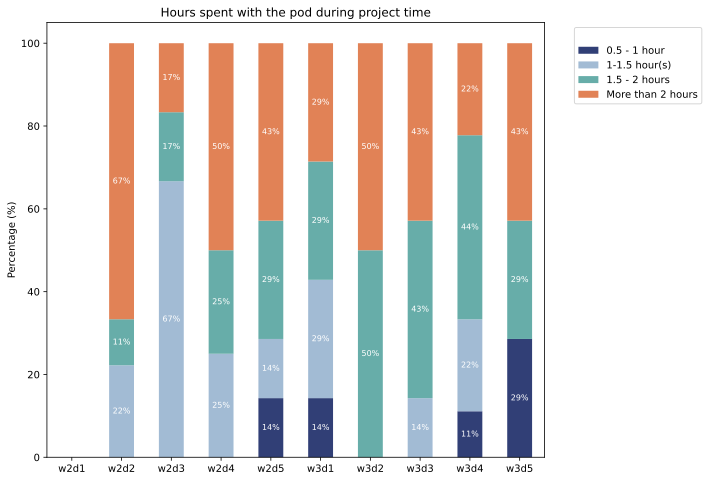

In [38]:
# @title
perc_q8_pivot = perc_q8_df.pivot(index='WeekDay', columns='Q8', values='Percentage')

# Create the stacked bar plot
ax = perc_q8_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), color=nma_colors, rot=0)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Hours spent with the pod during project time')

# Legend outside the plot
plt.legend(title=' ', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate segments with a non-zero value

            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f'{height:.0f}%', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig('H_project.png', dpi=400)
plt.show()

# Hours spent on preparatory work


`Approximately how many hours did you spend on preparatory work for today's session?`

In [39]:
# @title
mapping_numeric_q9 = {
    'A': 0.5,
    'B': 1.5,
    'C': 2.5,
    'D': 3.5}

mapping_q9 = {
    'A': 'Less than 1 hour',
    'B': '1-2 hours',
    'C': '2-3 hours',
    'D': 'More than 3 hours'}

combined_df['Q9_text'] = combined_df['Q9'].map(mapping_q9)
combined_df['Q9_numeric'] = combined_df['Q9'].map(mapping_numeric_q9)

# Calculate the overall average number of hours
average_hours_prep = round(combined_df['Q9_numeric'].mean(),2)
print("Overall average hours:", average_hours_prep)

print(' ')
print('*' *50)

# Calculate the average hours per WeekDay
average_prep_by_weekday = combined_df.groupby('WeekDay')['Q9_numeric'].mean()
print("Average hours per WeekDay:")
print(average_prep_by_weekday)

print(' ')
print('*' *50)

average_prep_TArole = combined_df.groupby('1')['Q9_numeric'].mean()
print("Average hours per TA Role:")
print(average_prep_TArole)

Overall average hours: 1.66
 
**************************************************
Average hours per WeekDay:
WeekDay
w2d1    NaN
w2d2   1.77
w2d3   1.50
w2d4   1.75
w2d5   1.88
w3d1   1.83
w3d2   1.40
w3d3   1.40
w3d4   1.77
w3d5   1.62
Name: Q9_numeric, dtype: float64
 
**************************************************
Average hours per TA Role:
1
Lead TA       1.50
Project  TA   1.26
Regular TA    1.83
Name: Q9_numeric, dtype: float64


<ipython-input-39-9ee017820a08>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_prep_by_weekday = combined_df.groupby('WeekDay')['Q9_numeric'].mean()


In [40]:
Perc_Q9 = combined_df.groupby('WeekDay', observed = False)['Q9_text'].value_counts(normalize=True) * 100
#print(Perc_Q9)

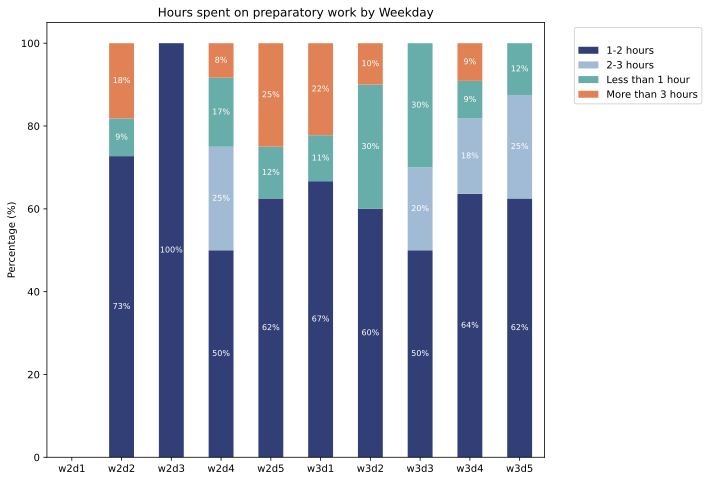

In [41]:
perc_q9_df = Perc_Q9.reset_index(name='Percentage')

perc_q9_pivot = perc_q9_df.pivot(index='WeekDay', columns='Q9_text', values='Percentage')

# Create the stacked bar plot
ax = perc_q9_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), color=nma_colors, rot=0)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Hours spent on preparatory work by Weekday')

# Legend outside the plot
plt.legend(title=' ', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate segments with a non-zero value

            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f'{height:.0f}%', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig('daily_preparation.png', dpi=400)
plt.show()

### **Is the preparation time different based on TAs role?**

In [42]:
perc_q9 = combined_df.groupby(['1', 'WeekDay'], observed = False)['Q9_text'].value_counts(normalize=True) * 100

perc_q9_df = perc_q9.reset_index(name='Percentage')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


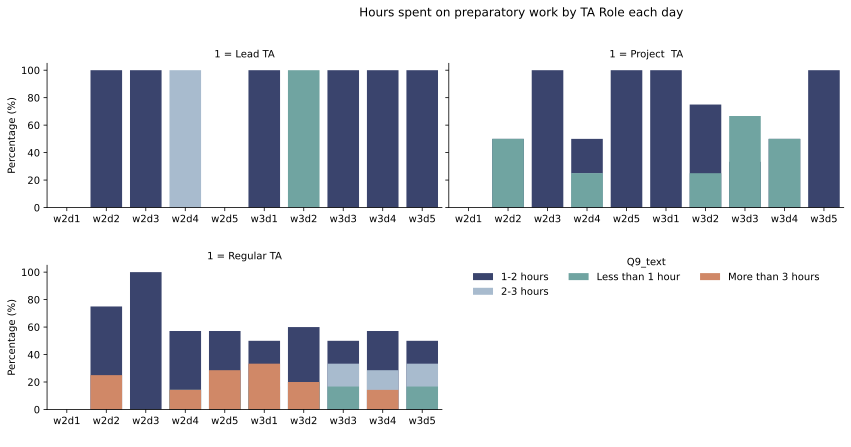

In [43]:
g = sns.FacetGrid(perc_q9_df,
    col="1", hue="Q9_text",
    col_wrap=2,        # 2 plots per row
    height=6,          # Height (in inches) of each facet
    aspect=2,          # Aspect ratio (width = height * aspect)
    palette=nma_colors)

g.map(sns.barplot, "WeekDay", "Percentage", errorbar=None)
g.add_legend(bbox_to_anchor=(0.8, 0.3), loc="lower right", borderaxespad=0., ncol=3)


g.fig.set_size_inches(14, 6)

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True)

    ax.set_xlabel(" ")
    ax.set_ylabel("Percentage (%)")

# Adjust the vertical spacing between rows
g.fig.subplots_adjust(hspace=0.4, top=0.85)

# Adjust the overall figure layout and add a super title.
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Hours spent on preparatory work by TA Role each day")
plt.savefig('preparatory work.png', dpi=400)
plt.show()


In [44]:
table = perc_q9_df.pivot_table(
    index=['1'],
    columns='Q9_text',
    values='Percentage',
    fill_value=0)

# Reset the index
table_reset = table.reset_index()

q9_columns = [col for col in table_reset.columns if col not in ['1']]

# Format the Q9 columns in the DataFrame
for col in q9_columns:
    table_reset[col] = table_reset[col].apply(lambda x: f"{x:.2f}%")

print(tabulate(table_reset, headers='keys', tablefmt='psql', showindex=False))

+-------------+-------------+-------------+--------------------+---------------------+
| 1           | 1-2 hours   | 2-3 hours   | Less than 1 hour   | More than 3 hours   |
|-------------+-------------+-------------+--------------------+---------------------|
| Lead TA     | 60.00%      | 10.00%      | 10.00%             | 0.00%               |
| Project  TA | 65.83%      | 2.50%       | 21.67%             | 0.00%               |
| Regular TA  | 55.64%      | 10.95%      | 9.86%              | 13.55%              |
+-------------+-------------+-------------+--------------------+---------------------+


### **Preparation time per career status**

In [73]:
# # Convert Q9_text to categorical
# Q9_order = ["Less than 1 hour", "1-2 hours", "2-3 hours", "More than 3 hours"]

# combined_df['Q9_text2'] = pd.Categorical(combined_df['Q9_text'], categories=Q9_order, ordered=True)

In [77]:
perc_q9_career = combined_df.groupby(['career_status', '1'], observed = True)['Q9_text'].value_counts(normalize=True) * 100

df_career = perc_q9_career.reset_index(name='Percentage')

In [78]:
table = df_career.pivot_table(index=['1', 'career_status'], columns='Q9_text', values='Percentage', fill_value=0)

table_reset = table.reset_index()

q9_columns = [col for col in table_reset.columns if col not in ['1']]

for col in q9_columns:
    table_reset[col] = table_reset[col].apply(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x)
print(tabulate(table_reset, headers='keys', tablefmt='psql', showindex=False))

+-------------+----------------------------+-------------+-------------+--------------------+---------------------+
| 1           | career_status              | 1-2 hours   | 2-3 hours   | Less than 1 hour   | More than 3 hours   |
|-------------+----------------------------+-------------+-------------+--------------------+---------------------|
| Lead TA     | lecturer_professor_faculty | 100.0%      | 0.0%        | 0.0%               | 0.0%                |
| Lead TA     | postdoc                    | 75.0%       | 12.5%       | 12.5%              | 0.0%                |
| Project  TA | masters_student            | 100.0%      | 0.0%        | 0.0%               | 0.0%                |
| Project  TA | other                      | 40.0%       | 0.0%        | 60.0%              | 0.0%                |
| Project  TA | phd_student                | 0.0%        | 25.0%       | 75.0%              | 0.0%                |
| Project  TA | undergraduate_student      | 100.0%      | 0.0%        |

# Break duration

*Non mandatory* - *Only for Lead and Regular TA*

Approximately how long of a break did you get during your work hours today?

In [49]:
# @title
mapping_numeric_q10 = {
    'A': 0.5,
    'B': 1.5,
    'C': 2.5}
combined_df['Q10_numeric'] = combined_df['Q10'].map(mapping_numeric_q10)

mapping_Q10 = {
    'A': 'Less than 1 hour',
    'B': '1-2 hrs',
    'C': 'More than 2 hrs'}

combined_df['Q10_text'] = combined_df['Q10'].map(mapping_Q10)


# Calculate the overall average number of hours
average_hours_break = round(combined_df['Q10_numeric'].mean(),2)
print("Overall average hours:", average_hours_break)

print(' ')
print('*' *50)

# Calculate the average hours per WeekDay
average_break_by_weekday = combined_df.groupby('WeekDay')['Q10_numeric'].mean()
print("Average hours per WeekDay:")
print(average_break_by_weekday)

print(' ')
print('*' *50)

average_break_TArole = combined_df.groupby('1')['Q10_numeric'].mean()
print("Average hours per TA Role:")
print(average_break_TArole)

Overall average hours: 1.2
 
**************************************************
Average hours per WeekDay:
WeekDay
w2d1    NaN
w2d2   0.94
w2d3   1.33
w2d4   1.25
w2d5   1.21
w3d1   1.36
w3d2   1.00
w3d3   1.07
w3d4   1.28
w3d5   1.36
Name: Q10_numeric, dtype: float64
 
**************************************************
Average hours per TA Role:
1
Lead TA       1.28
Project  TA    NaN
Regular TA    1.18
Name: Q10_numeric, dtype: float64


<ipython-input-49-12212daa77d6>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_break_by_weekday = combined_df.groupby('WeekDay')['Q10_numeric'].mean()


In [50]:
perc_q10 = combined_df.groupby('WeekDay', observed=False)['Q10_text'].value_counts(normalize=True) * 100

perc_q10_df = perc_q10.reset_index(name='Percentage')

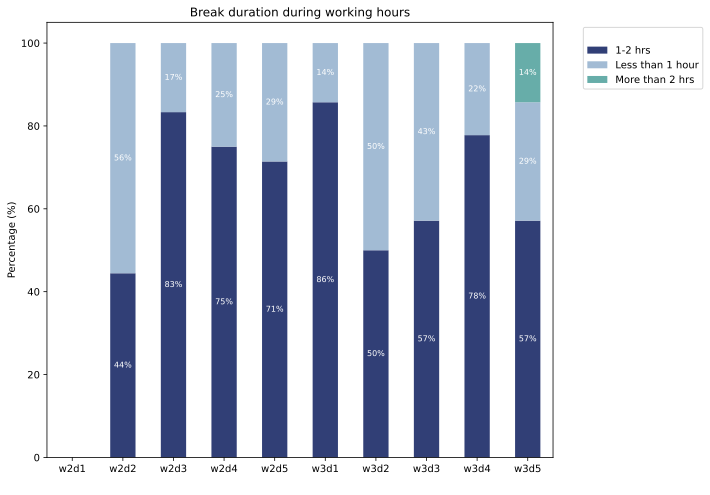

In [51]:
# @title
nma_colors = get_colors("ALL")

perc_q10_pivot = perc_q10_df.pivot(index='WeekDay', columns='Q10_text', values='Percentage')

# Create the stacked bar plot
ax = perc_q10_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), color=nma_colors, rot=0)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Break duration during working hours')

# Legend outside the plot
plt.legend(title=' ', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate segments with a non-zero value

            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f'{height:.0f}%', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig('H_break.png', dpi=400)
plt.show()

# Number of project group met

*Non mandatory* - *Only for Project TA*

`How many project groups did you meet with today?`

In [52]:
mapping_Q11 = {
    'A': '0',
    'B': '1',
    'C': '2',
    'D': '3',
    'E': '4',
    'F': '5',
    'G': '6',
    'H':'7', 'I': '8', 'L': 'More than 8'}

combined_df['Q11'] = combined_df['Q11'].map(mapping_Q11)

In [53]:
perc_q11 = combined_df.groupby('WeekDay', observed = False)['Q11'].value_counts(normalize=True) * 100

perc_q11_df = perc_q11.reset_index(name='Percentage')

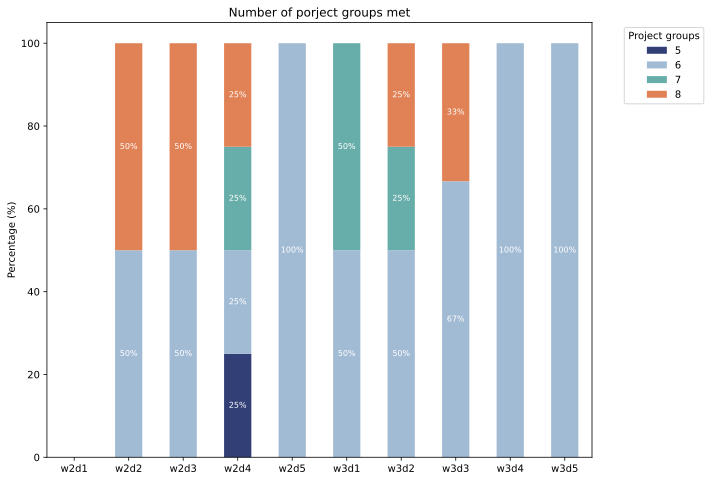

In [54]:
perc_q11_df = perc_q11.reset_index(name='Percentage')

perc_q11_pivot = perc_q11_df.pivot(index='WeekDay', columns='Q11', values='Percentage')

# Create the stacked bar plot
ax = perc_q11_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), color=nma_colors, rot=0)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Number of porject groups met')

# Legend outside the plot
plt.legend(title='Project groups', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate segments with a non-zero value

            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f'{height:.0f}%', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig('groupMet.png', dpi=400)
plt.show()

# Meeting duration with project group

*Non mandatory*  - *Only for Project TA*

`On an average what was the duration of your meetings with each project group?`

In [55]:
mapping_Q12 = {
    'A': '10-15 mins',
    'B': '15-30 mins',
    'C': '30-45 mins',
    'D': '45 mins to 1 hour',
    'E': 'More than 1 hour'}

combined_df['Q12'] = combined_df['Q12'].map(mapping_Q12)

In [56]:
perc_q12 = combined_df.groupby('WeekDay', observed = False)['Q12'].value_counts(normalize=True) * 100

perc_q12_df = perc_q12.reset_index(name='Percentage')

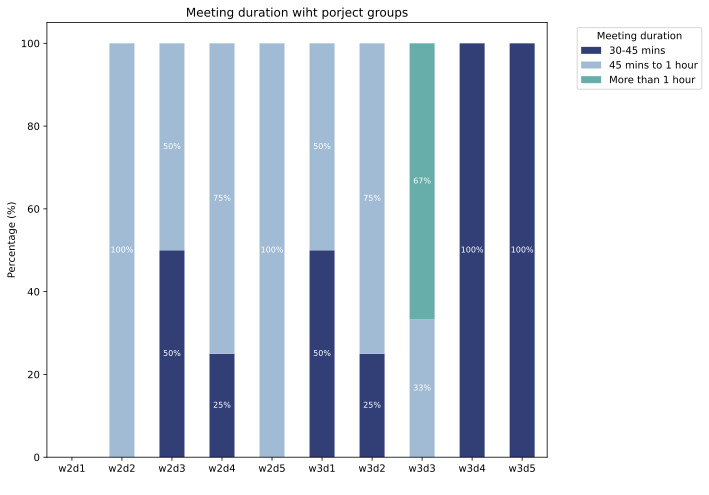

In [57]:
perc_q12_df = perc_q12.reset_index(name='Percentage')

perc_q12_pivot = perc_q12_df.pivot(index='WeekDay', columns='Q12', values='Percentage')

# Create the stacked bar plot
ax = perc_q12_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), color=nma_colors, rot=0)

plt.xlabel(' ')
plt.ylabel('Percentage (%)')
plt.title('Meeting duration wiht porject groups')

# Legend outside the plot
plt.legend(title='Meeting duration', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate segments with a non-zero value

            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f'{height:.0f}%', ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.savefig('groupMeeting time.png', dpi=400)
plt.show()

# Feedback: support for TA role

In what ways do you think we can better support you in your role as a TA (other than responding to questions asked via emails and discord support tickets)? Please provide specific suggestions

In [58]:
count_Q13 = combined_df.groupby('WeekDay')['Q13'].count()
print(count_Q13)

WeekDay
w2d1    0
w2d2    2
w2d3    2
w2d4    1
w2d5    1
w3d1    0
w3d2    2
w3d3    0
w3d4    1
w3d5    0
Name: Q13, dtype: int64


<ipython-input-58-3465028f6291>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_Q13 = combined_df.groupby('WeekDay')['Q13'].count()


In [59]:
grouped1 = combined_df.groupby('WeekDay')['Q13'].unique()

for weekday, answers in grouped1.items():
    print("\033[1m" + f"Weekday: {weekday}" + "\033[0m")

    for answer in answers:
        print(answer)
    print("-" * 40)

Weekday: w2d1
nan
----------------------------------------
Weekday: w2d2
nan
Better preparation before the course + i have an extra pod with foundation models but it’s not my expertise ad there’s no template to get started with. I am handling the pod as we go but I don’t think it will be fair for the students in these groups.
And regarding the relationship between project TA and regular Ta and also lead TAs, there is gap.
Better pay, it is way lesser than last year
----------------------------------------
Weekday: w2d3
nan
I would like some mentoring as well 
There are currently 5 active members in my pod, hence would welcome new members, or wouldn't mind if a pod merger is performed.
----------------------------------------
Weekday: w2d4
nan
Special project related content support
----------------------------------------
Weekday: w2d5
nan
We need more detailed contents such as video or technical illustrations.
----------------------------------------
Weekday: w3d1
nan
----------------

<ipython-input-59-50f807e0d924>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped1 = combined_df.groupby('WeekDay')['Q13'].unique()


# Feedback: additional comments

Do you have any additional comments or feedback you would like to share regarding your experience as a TA?

In [60]:
grouped2 = combined_df.groupby('WeekDay')['Q14'].unique()

for weekday, answers in grouped2.items():
    print("\033[1m" + f"Weekday: {weekday}" + "\033[0m")

    for answer in answers:
        print(answer)
    print("-" * 40)

Weekday: w2d1
I think the progress is quite good in my pod, and students are quite actively participating. So, all good. 
7-8 are attending the project. 3-4 for tutorials. One person Hanieh said they have ADHD and are not willing to switch on their microphone or camera to interact with project members. They want to work alone. I tried to convince them but I don't think it's working. I might need someone else to try speaking with them. I conveyed the same message to my Lead TA and Project TA.
They're very quiet sometimes and very much shy to collaborate with each other. I'm coming up with so many questions about the tutorials to discuss with them and sometimes I feel like I'm the one who is talking.
Very active students
nan
----------------------------------------
Weekday: w2d2
nan
Dealing with individuals who are extremely reluctant to vocalize their thoughts can be quite challenging.
I think we may need a quick 15 minute talk between regular TA and project TA so that we can share any 

<ipython-input-60-29bcdf66a8bb>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped2 = combined_df.groupby('WeekDay')['Q14'].unique()


#  Q15 - attending     

This question is present in w2d1 only. It's a free text.

`How many students are actively attending your pod?`

In [61]:
combined_df['Q15'].unique()


array([11.,  4., 12.,  9.,  5.,  7., 10., nan])

In [62]:
average_attendance = combined_df['Q15'].mean()
average_attendance

8.444444444444445

On average 8 students per pod are attending the course after 1 week.

# Q18 - never showed

This question is present in w2d1 only. It's a free text.

`How many students that are listed on the Portal as in your pod never showed up`

In [63]:
combined_df['Q18'].unique()

array([ 3.,  4.,  7.,  5.,  8.,  2., nan])

In [64]:
combined_df['Q18'].mean()

4.888888888888889

On average 5 students per pod didnt show up after 1 week.

# Q16 - projects    

This question is present in w2d1 only. It's a free text.

`How many students are actively taking part in the Projects portion?`

In [65]:
combined_df['Q16'].unique()

array([11.,  8., 12.,  9.,  5.,  7., 10.,  6., nan])

In [66]:
average_project = combined_df['Q16'].mean()
average_project

8.777777777777779

On average 9 students per pod are attending the project part of the course after 1 week.